In [29]:
import numpy as np
import qiskit as q
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ, QuantumRegister, AncillaRegister
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Statevector
from qiskit.visualization import array_to_latex
import matplotlib as mpl
import matplotlib.pyplot as plt

In [30]:
#parameters

M = 64 # lattices

w1 = 0.5 
w2 = 0.5 
e1 = 1   ##right
e2 = -1  ##left
cs = 1   ##speed of sound
u = 0.2  ##advection 


x = w1*(1+e1*u/cs**2)
y = w2*(1+e2*u/cs**2)

lambda1 = np.arccos(x)
lambda2 = np.arccos(y)

In [31]:
def oneStep(lambda1,lambda2):
    
    #initializing
    n = int(np.log2(2*M))
    q = QuantumRegister(n,'q')
    a = AncillaRegister(1,'a')

    qc = QuantumCircuit(q)
    qc.add_register(a)
     
    qc.barrier()

    #collisions
    def createC(lambda1, lambda2, isC1 = True):
    
        if not isC1:
            lambda1 *= -1
            lambda2 *= -1


        qc=QuantumCircuit(2)

        #phase1 -> x -> phase1 -> x -----ctrl=0
        qc.cp(lambda1, 0 ,1 , ctrl_state = 0)
        qc.cx(0, 1, ctrl_state = 0)
        qc.cp(lambda1, 0, 1, ctrl_state = 0)
        qc.cx(0, 1, ctrl_state = 0)

        #phase2 -> x -> phase2 -> x -----ctrl=1 is default
        qc.cp(lambda2, 0, 1, ctrl_state = 1)
        qc.cx(0, 1)
        qc.cp(lambda2, 0, 1, ctrl_state = 1)
        qc.cx(0, 1)

        return qc
    
    C1 = createC(lambda1, lambda2, True)
    c1gate = C1.to_gate(label = 'c1')
    C2 = createC(lambda1, lambda2, False)
    c2gate = C2.to_gate(label = 'c2')
    
    
    #####adding steps to circuit
    qc.h(a)
    qc.append(c1gate.control(1, ctrl_state = 0),[a,n-1,1])
    qc.append(c2gate.control(1, ctrl_state = 1),[a,n-1,1])
    qc.h(a)
    qc.draw()
    
    
    
    
    
    
    
    #propagation
    def rshift(n):
        circ = QuantumCircuit(n-1)
        for i in range(n-1):
            if i == n-2:
                circ.x(i)
            else:
                circ.mcx(list(range(i+1,n-1)), i)
        return circ

    def lshift(n):
        circ = QuantumCircuit(n-1)
        for i in reversed(range(n-1)):
            if i == n-2:
                circ.x(i)
            else:
                circ.mcx(list(range(i+1,n-1)), i)
        return circ
    
    qc.barrier()
    R = rshift(n).to_gate(label = "R").control(1, ctrl_state = 0)#.control(1, ctrl_state = 0)
    L = lshift(n).to_gate(label = "L").control(1, ctrl_state = 1)#.control(1, ctrl_state = 0)
    
    cbits = [n-1]
    cbits.extend([i for i in range(n-2,-1,-1)])  

    qc.append(R,cbits)
    qc.append(L,cbits)

    
    ######################### macros
    qc.swap(a,n-1)
    qc.h(a)

    return qc

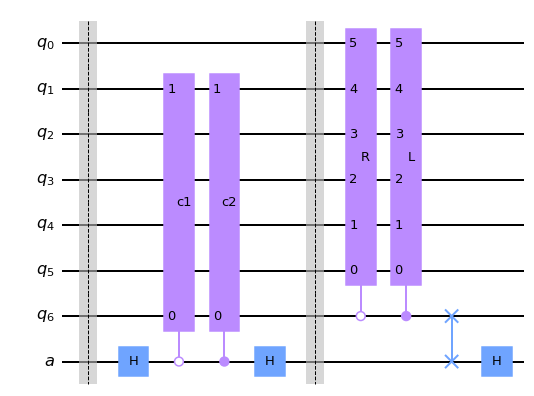

In [32]:
qc = oneStep(np.arccos(x),np.arccos(y))
qc.draw()

In [33]:
#### initialState
initState = np.ones(M)/10  #0.1 everywhere
initState[12] = 0.2
# initState[11] = 0.1+0.1*2/3
# initState[13] = initState[11]
# initState[10] = 0.1+.1/3
# initState[14] = initState[10]
initState = np.concatenate((initState,initState))
#### statevector
SV = Statevector(initState/np.linalg.norm(initState)).expand([1,0])
initSV = SV #save for future reference

In [34]:
def timestep(sv):
    return sv.evolve(qc)

def graph(sv, color = "red"):
    plt.plot(list(range(0,M,1)), np.array(sv)[:M:1],color)
    plt.plot(list(range(M,2*M,1)), np.array(sv)[M:2*M:1],color)
    plt.plot(list(range(2*M,3*M,1)), np.array(sv)[2*M:3*M:1],color)
    plt.plot(list(range(3*M,4*M,1)), np.array(sv)[3*M::1],color)
    
def hres1(sv):
    plt.plot(list(range(1,M,2)), np.array(sv)[1:M:2])
    
def hres(sv):
    plt.plot(list(range(0,M,1)), np.array(sv)[:M])
    
def renormalize(sv):
    return Statevector(np.array(sv)*np.linalg.norm(sv)*np.sqrt(2))

def reinit(sv):
    tmp = np.array(sv)[:M]
    tmp = np.concatenate((tmp,tmp))
    return Statevector(tmp/np.linalg.norm(tmp)).expand([1,0])

/Users/sriharshakocherla/Documents/projects/pythonProjects/quantum/quant/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/sriharshakocherla/Documents/projects/pythonProjects/quantum/quant/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/sriharshakocherla/Documents/projects/pythonProjects/quantum/quant/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/sriharshakocherla/Documents/projects/pythonProjects/quantum/quant/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


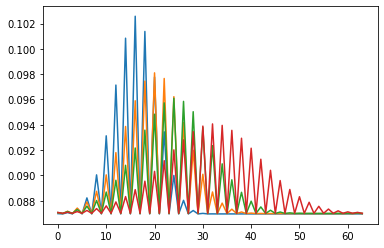

In [35]:
# hres(initSV,'red')
for i in range(1,101):
    SV = timestep(SV)
    SV = renormalize(SV)
    if i%20==0 and i!=80:
        hres(SV)
    SV = reinit(SV)